# Đánh giá PhoWhisper: Độ chính xác & Độ trễ
Notebook này chuẩn bị môi trường Google Colab để tải mô hình PhoWhisper, chạy thử trên các file âm thanh tiếng Việt và tính hai chỉ số quan trọng: Word Error Rate (WER) và độ trễ xử lý cho đoạn âm thanh 10 giây.

## 1. Environment Setup on Google Colab
Cài đặt thư viện cần thiết (torch/torchaudio/transformers/jiwer/soundfile…), kiểm tra GPU, đồng thời chuẩn bị biến môi trường `HF_TOKEN` nếu repository Hugging Face yêu cầu quyền truy cập.

In [ ]:
!pip install -q --upgrade pip
!pip install -q torch torchaudio transformers==4.39.3 accelerate huggingface_hub==0.23.4 jiwer librosa soundfile pandas matplotlib

In [ ]:
import os
from pathlib import Path

import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Sử dụng thiết bị: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Sử dụng thiết bị: cuda
GPU: Tesla T4


## 2. Download PhoWhisper Checkpoint từ Hugging Face
Tải checkpoint PhoWhisper bằng `huggingface_hub.snapshot_download`, lưu cache tại `/content/models` để tái sử dụng giữa các lần chạy Colab.

In [103]:
from huggingface_hub import snapshot_download

MODEL_ID = "vinai/phowhisper-medium"
MODEL_CACHE = Path("/content/models/PhoWhisper")
MODEL_CACHE.mkdir(parents=True, exist_ok=True)

snapshot_download(
    repo_id=MODEL_ID,
    cache_dir=MODEL_CACHE,
    local_dir=MODEL_CACHE,
    local_dir_use_symlinks=False,
    token=os.getenv("HF_TOKEN"),
)

print(f"Đã sẵn sàng checkpoint tại: {MODEL_CACHE}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1194: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Đã sẵn sàng checkpoint tại: /content/models/PhoWhisper


## 3. Load Evaluation Audio Clips và Reference Transcript
Mount Google Drive (hoặc tải file trực tiếp), chuẩn hóa sample rate về 16 kHz, đồng thời lưu bảng tham chiếu gồm đường dẫn file và transcript gốc để tính WER.

In [104]:
import pandas as pd
import soundfile as sf
import librosa
import numpy as np

DEFAULT_AUDIO_ROOT = Path.cwd() / "data"

DEFAULT_AUDIO_ROOT.mkdir(parents=True, exist_ok=True)

audio_references = [
    {
        "audio_path": DEFAULT_AUDIO_ROOT / "1.moi_truong_yen_tinh.mp3",
        "reference_text": "Một buổi chiều yên tĩnh tôi ngồi bên hiên nhà lắng nghe tiếng gió thổi qua hàng cây xanh mát.",
    },
    {
        "audio_path": DEFAULT_AUDIO_ROOT / "2.moi_truong_tap_am_nen.mp3",
        "reference_text": "Trẻ trẻ anh em đi trải nghiệm các thứ đồ ô kê nó năng lượng đúng không anh em, đó ví dụ mà mấy cô chú mà kiểu mà lớn tuổi tí thì con nghĩ đi vẫn được, nhưng mà ở trên bờ thôi chứ mà đi nãy đi cái kia thì nó cũng hơi căng."
    },
    {
        "audio_path": DEFAULT_AUDIO_ROOT / "3.tu_ngu_chuyen_nganh.mp3",
        "reference_text": "báo cáo của Microsoft tại Thành phố Hồ Chí Minh phân tích công suất phản kháng trong hệ thống blockchain do chuyên gia Trương Công Hiếu trình bày.",
    },

]

TARGET_SR = 16_000
normalized_entries = []

for item in audio_references:
    audio_path = Path(item["audio_path"])  # đảm bảo Path
    if not audio_path.exists():
        raise FileNotFoundError(
            f"Không tìm thấy file {audio_path}. Hãy upload hoặc cập nhật đường dẫn trong audio_references."
        )
    waveform, _ = librosa.load(audio_path.as_posix(), sr=TARGET_SR)
    normalized_path = audio_path.with_name(audio_path.stem + "_16k.wav")
    sf.write(normalized_path, waveform, TARGET_SR)
    duration = len(waveform) / TARGET_SR
    normalized_entries.append(
        {
            "audio_path": normalized_path,
            "reference_text": item["reference_text"].strip(),
            "duration_sec": round(duration, 2),
        }
    )

eval_df = pd.DataFrame(normalized_entries)
print("Danh sách file đã chuẩn hóa 16 kHz:")
display(eval_df)

Danh sách file đã chuẩn hóa 16 kHz:


,audio_path,reference_text,duration_sec
0,/content/data/1.moi_truong_yen_tinh_16k.wav,Một buổi chiều yên tĩnh tôi ngồi bên hiên nhà ...,5.59
1,/content/data/2.moi_truong_tap_am_nen_16k.wav,Trẻ trẻ anh em đi trải nghiệm các thứ đồ ô kê ...,13.40
2,/content/data/3.tu_ngu_chuyen_nganh_16k.wav,báo cáo của Microsoft tại Thành phố Hồ Chí Min...,6.69


## 4. Build PhoWhisper Transcription Pipeline
Khởi tạo `AutoProcessor` và `AutoModelForSpeechSeq2Seq`, ép kiểu phù hợp với GPU (float16 nếu có CUDA). Pipeline sẽ nhận numpy array hoặc file path và trả về văn bản tiếng Việt.

In [ ]:
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline

processor = AutoProcessor.from_pretrained(MODEL_CACHE)
forced_decoder_ids = processor.get_decoder_prompt_ids(language="vi", task="transcribe")

def build_phowhisper_pipeline(
    model_dir: Path,
    device: str = DEVICE,
    chunk_length_s: float = 30.0,
    batch_size: int = 8,
    enable_timestamps: bool = False,
):
    dtype = torch.float16 if device == "cuda" else torch.float32

    model = AutoModelForSpeechSeq2Seq.from_pretrained(
        model_dir,
        torch_dtype=dtype,
        low_cpu_mem_usage=True,
    )
    model.to(device)
    model.generation_config.forced_decoder_ids = forced_decoder_ids

    return pipeline(
        task="automatic-speech-recognition",
        model=model,
        tokenizer=processor.tokenizer,
        feature_extractor=processor.feature_extractor,
        chunk_length_s=chunk_length_s,
        batch_size=batch_size,
        return_timestamps=enable_timestamps,
        device=0 if device == "cuda" else -1,
    )


asr_pipeline = build_phowhisper_pipeline(MODEL_CACHE)
print("Pipeline sẵn sàng!")

Pipeline sẵn sàng!


## 5. Compute Word Error Rate (WER)
WER được tính theo công thức $WER = \frac{S + D + I}{N}$ với $S$: số từ bị thay thế, $D$: số từ bị xóa, $I$: số từ chèn, $N$: tổng số từ chuẩn. Sử dụng `jiwer` để so sánh transcript dự đoán và transcript gốc cho từng file.

In [ ]:
from jiwer import wer
import numpy as np 
import torch


def normalize_text(text: str) -> str:
    return " ".join(text.strip().lower().split())


def transcribe_and_score(row):
    audio_path = row["audio_path"]
    audio_array, sr = librosa.load(audio_path.as_posix(), sr=asr_pipeline.feature_extractor.sampling_rate)

    input_features = processor.feature_extractor(
        audio_array,
        sampling_rate=sr,
        return_tensors="pt"
    ).input_features.to(DEVICE)

    if asr_pipeline.model.dtype == torch.float16:
        input_features = input_features.to(torch.float16)

    generated_ids = asr_pipeline.model.generate(
        input_features=input_features,
    )
    predicted_text = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predicted_text = predicted_text.strip() # Remove leading/trailing whitespace

    score = wer(normalize_text(row["reference_text"]), normalize_text(predicted_text))
    return pd.Series({
        "predicted_text": predicted_text,
        "wer": score,
    })


eval_df = pd.concat([eval_df, eval_df.apply(transcribe_and_score, axis=1)], axis=1)

eval_df

,audio_path,reference_text,duration_sec,predicted_text,wer
0,/content/data/1.moi_truong_yen_tinh_16k.wav,Một buổi chiều yên tĩnh tôi ngồi bên hiên nhà ...,5.59,một buổi chiều yên tĩnh tôi ngồi bên hiên nhà ...,0.000000
1,/content/data/2.moi_truong_tap_am_nen_16k.wav,Trẻ trẻ anh em đi trải nghiệm các thứ đồ ô kê ...,13.40,trẻ trẻ anh em đi trải nghiệm các thứ đồ ô kê ...,0.053571
2,/content/data/3.tu_ngu_chuyen_nganh_16k.wav,báo cáo của Microsoft tại Thành phố Hồ Chí Min...,6.69,báo cáo của microsoft tại thành phố hồ chí min...,0.071429


## 6. Measure 10-Second Latency
Chuẩn hóa mỗi đoạn audio về đúng 10 giây (cắt hoặc padding), sau đó dùng `time.perf_counter` để đo thời gian pipeline xử lý. Có thể lặp nhiều lần để lấy trung bình ổn định.

In [ ]:
import time
import numpy as np 


def prepare_ten_second_clip(audio_path: Path, sample_rate: int = 16_000) -> np.ndarray:
    waveform, _ = librosa.load(audio_path.as_posix(), sr=sample_rate)
    target_samples = sample_rate * 10
    if len(waveform) >= target_samples:
        return waveform[:target_samples]
    pad = target_samples - len(waveform)
    return np.pad(waveform, (0, pad))


def measure_latency_seconds(audio_array: np.ndarray, sample_rate: int) -> float:
    input_features = processor.feature_extractor(
        audio_array,
        sampling_rate=sample_rate,
        return_tensors="pt"
    ).input_features.to(DEVICE)

    if asr_pipeline.model.dtype == torch.float16:
        input_features = input_features.to(torch.float16)

    start = time.perf_counter()
    asr_pipeline.model.generate(
        input_features=input_features,
    )
    end = time.perf_counter()
    return end - start


latencies = []
for _, row in eval_df.iterrows():
    clip = prepare_ten_second_clip(row["audio_path"], sample_rate=asr_pipeline.feature_extractor.sampling_rate)
    latency = measure_latency_seconds(clip, asr_pipeline.feature_extractor.sampling_rate)
    latencies.append(latency)

eval_df["latency_10s"] = latencies
print("Latency (giây) cho từng file 10s:")
eval_df[["audio_path", "latency_10s"]]

Latency (giây) cho từng file 10s:


,audio_path,latency_10s
0,/content/data/1.moi_truong_yen_tinh_16k.wav,0.909205
1,/content/data/2.moi_truong_tap_am_nen_16k.wav,1.320972
2,/content/data/3.tu_ngu_chuyen_nganh_16k.wav,1.521265


## 7. Summarize Metrics
Tổng hợp bảng kết quả gồm tên file, độ dài, transcript dự đoán, WER và latency; đồng thời trực quan hóa bằng matplotlib và lưu ra CSV để báo cáo.

Bảng tổng hợp chỉ số:


,audio_name,duration_s,wer,latency_s,reference_text,predicted_text
0,1.moi_truong_yen_tinh_16k.wav,5.59,0.000000,0.909205,Một buổi chiều yên tĩnh tôi ngồi bên hiên nhà ...,một buổi chiều yên tĩnh tôi ngồi bên hiên nhà ...
1,2.moi_truong_tap_am_nen_16k.wav,13.40,0.053571,1.320972,Trẻ trẻ anh em đi trải nghiệm các thứ đồ ô kê ...,trẻ trẻ anh em đi trải nghiệm các thứ đồ ô kê ...
2,3.tu_ngu_chuyen_nganh_16k.wav,6.69,0.071429,1.521265,báo cáo của Microsoft tại Thành phố Hồ Chí Min...,báo cáo của microsoft tại thành phố hồ chí min...


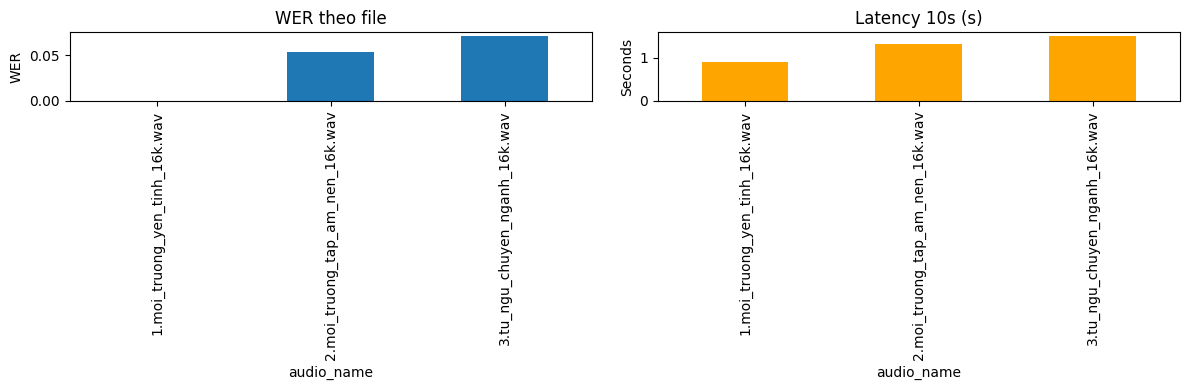

Đã lưu kết quả ra /content/phowhisper_metrics.csv


In [108]:
import matplotlib.pyplot as plt

metrics_df = eval_df.copy()
metrics_df["audio_name"] = metrics_df["audio_path"].apply(lambda p: Path(p).name)
metrics_df = metrics_df[["audio_name", "duration_sec", "wer", "latency_10s", "reference_text", "predicted_text"]]
metrics_df.rename(columns={"duration_sec": "duration_s", "latency_10s": "latency_s"}, inplace=True)

print("Bảng tổng hợp chỉ số:")
display(metrics_df)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
metrics_df.plot(x="audio_name", y="wer", kind="bar", ax=axes[0], legend=False, title="WER theo file")
metrics_df.plot(x="audio_name", y="latency_s", kind="bar", ax=axes[1], color="orange", legend=False, title="Latency 10s (s)")
axes[0].set_ylabel("WER")
axes[1].set_ylabel("Seconds")
plt.tight_layout()
plt.show()

output_csv = Path("/content/phowhisper_metrics.csv")
metrics_df.to_csv(output_csv, index=False, encoding="utf-8")
print(f"Đã lưu kết quả ra {output_csv}")

### Ghi chú
- Đảm bảo mỗi file đánh giá có transcript gốc chính xác để WER phản ánh chất lượng thực tế.
- Để so sánh mô hình khác, chỉ cần đổi `MODEL_ID` và chạy lại notebook.
- Có thể lưu notebook và CSV vào Google Drive để tiện theo dõi các lần benchmark khác nhau.